In [1]:
%reset
import tensorflow as tf
import keras
import pickle as pk
import matplotlib.pyplot as pl
import matplotlib
import numpy as np
import pdb

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


2022-02-16 20:01:07.544004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
date = "2_16_22"

# The neural network architecture that we'll use in the example below is based on:

See https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

## Data location and dimensions

In [3]:
#The data are "cutouts" from full-sky maps made from observations by the Planck satellite.
#These maps were constructed at an observing frequency of 857 GHz
data_dir = './cutout_data/'
# this file contains some cutouts that are "off star", i.e. centered at random locations on the sky
# and not on star locations
offstar_file = 'cutouts_1000offstarfirstpass_01.pk'
offstar_multi = 'cutouts_1000offstarmultifreq_01.pk'

## Load the cutout data

In [4]:
#multi freq data
cutout_data_mf = pk.load(open(data_dir + offstar_multi, 'rb'))
print(cutout_data_mf.keys())
ll = cutout_data_mf['l'] # galatic longitude of the cutout
bb = cutout_data_mf['b'] # galactic latitude of the cutout

#get cutouts
cutouts_orig_mf = cutout_data_mf['cutouts']
print(cutout_data_mf['planck_files'])
print(cutouts_orig_mf.shape)

#one-axis array
cutouts_multi = np.append(cutouts_orig_mf[0], cutouts_orig_mf[1], axis=0)
print(cutouts_multi.shape)

dict_keys(['planck_files', 'cutouts', 'l', 'b'])
['planck_545.fits', 'planck_857.fits']
(2, 1000, 200, 200)
(2000, 200, 200)


## Plot a few cutouts

<Figure size 432x288 with 0 Axes>

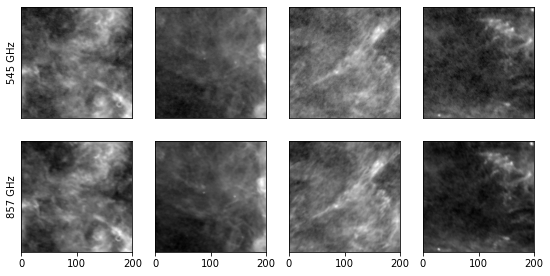

In [5]:
#plot some cutouts from both frequencies
pl.gray()
nplots = 4
fig, ax = pl.subplots(2,nplots, figsize = (nplots*2.3, 4.5))
for ii in range(0,nplots):
    ax[0,ii].imshow(np.log(cutouts_multi[ii,:,:]))
    ax[1,ii].imshow(np.log(cutouts_multi[1000 + ii,:,:]))
    
    ax[0,ii].yaxis.set_visible(False)
    ax[0,ii].xaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)

    ax[1,ii].set_xlim(0,200)

ax[0,0].yaxis.set_visible(True)
ax[0,0].set_ylabel("545 GHz")
ax[0,0].set_yticks([])

ax[1,0].yaxis.set_visible(True)
ax[1,0].set_ylabel("857 GHz")
ax[1,0].set_yticks([])

fig.savefig(f"network_output/images/12_200_data.png")


## Reduce the dimensionality of the cutouts
And generate more data by flipping images

In [6]:
#The iniital cutouts have a dimension of 200x200.  We'll reduce the dimension to dim_reduced x dim_reduced
#to speed up the analysis
dim_reduced = 32
#We're going to mask out a small part of the center of the cutout with dimension dim_mask x dim_mask
#This reduction by 4 is hardcoded somewhere deep in keras
dim_mask = int(dim_reduced/4)

(72000, 32, 32)


<Figure size 432x288 with 0 Axes>

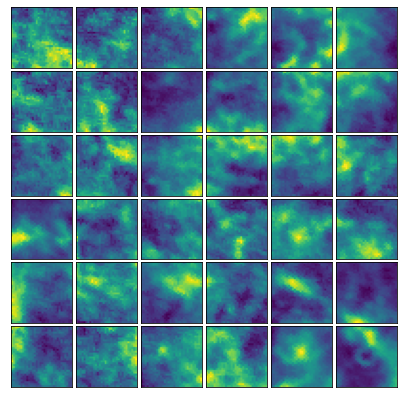

In [7]:
#make cutouts of smaller dimensions by tiling the original 200x200 image nxn times
pl.viridis()
n_cuts = int(200/dim_reduced)

cutouts_many = np.empty([0,dim_reduced,dim_reduced])

fig, ax = pl.subplots(n_cuts,n_cuts, figsize = (7,7))

#show one of the images tiled, since they do not havce absoulte scale thy might not appear to match
for x in range(0,n_cuts):
    min_x = x * dim_reduced
    max_x = (x+1) * dim_reduced
    for y in range(0,n_cuts):
        min_y = y * dim_reduced
        max_y = (y+1) * dim_reduced
        some_cutouts = cutouts_multi[:, min_x:max_x, min_y:max_y]
        cutouts_many = np.append(cutouts_many,some_cutouts,axis=0)
        ax[x,y].imshow((some_cutouts[0,:,:]))
        ax[x,y].yaxis.set_visible(False)
        ax[x,y].xaxis.set_visible(False)

pl.subplots_adjust(wspace=0, hspace=0.05)
print(cutouts_many.shape)

(72000, 32, 32)
(288000, 32, 32)


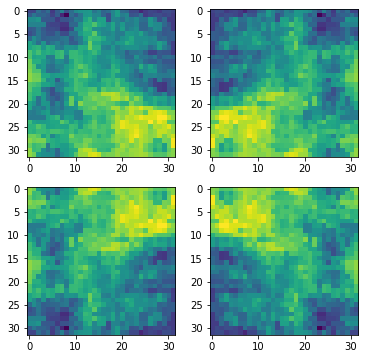

In [8]:
#to futher artificaly increase the dataset, all tiled images will be rotated and flipped effectively
#increasing our dataset by factor of 4

#indexing setup
cutouts = cutouts_many
end_shape = cutouts.shape[0]

#flip horizontaly and append
cutouts_fliplr = np.flip(cutouts,axis=2)
cutouts = np.append(cutouts,cutouts_fliplr,axis=0)

#flip all verticaly and append
cutouts_flipud = np.flip(cutouts,axis=1)
cutouts = np.append(cutouts,cutouts_flipud,axis=0)

#expected 4 times as large
print(cutouts_many.shape)
print(cutouts.shape)

#check orientation by plotting
fig, ax = pl.subplots(2,2, figsize = (6, 6))
ax[0,0].imshow(np.log(cutouts[0,:,:]))
ax[0,1].imshow(np.log(cutouts[end_shape,:,:]))

ax[1,0].imshow(np.log(cutouts[2*end_shape,:,:]))
ax[1,1].imshow(np.log(cutouts[3*end_shape,:,:]))
    
    
#fig.savefig('./network_out/example_images.png')

## Set up the neural network

In [9]:
#check if keras is using gpu instead of cpu cores
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2022-02-16 20:01:24.049881: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-16 20:01:24.051450: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-16 20:01:24.119007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-16 20:01:24.119917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-16 20:01:24.119942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-16 20

In [10]:
#since current order of images is quite regular we want to randomize to get an representative test/train split
#randomly shuffle but with a seed, so figueres have same indexes between runs

import random

random.seed(420)
random.shuffle(cutouts)

#THIS NOW MIGHT NEED CHANGE FOR TEST ON BATCH
#this is necesary for the network to run, since testiung is not done by batches 
#it cannot function with an extremely large dataset
test_size = 10000
split_index = int(cutouts.shape[0] - test_size)


cutouts_train = cutouts[:split_index,:,:]
cutouts_test = cutouts[split_index:,:,:]

print(cutouts_train.shape)
print(cutouts_test.shape)

(278000, 32, 32)
(10000, 32, 32)


In [11]:
from __future__ import print_function, division

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import losses
from tensorflow.keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = dim_reduced
        self.img_cols = dim_reduced
        self.mask_height = dim_mask
        self.mask_width = dim_mask
        #777777777777
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights = l_weights,
            #loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def mask_center(self, imgs):
        y1 = int(self.img_rows/2) - int(self.mask_height/2)
        y2 = y1 + self.mask_height
        x1 = int(self.img_rows/2) - int(self.mask_width/2)
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            missing_parts[i] = masked_img[y1:y2, x1:x2, :].copy()
            masked_img[y1:y2, x1:x2, :] = -100
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def train(self, epochs, batch_size, sample_interval):

        # Load the dataset
        X_train = np.expand_dims(np.log(cutouts_train),axis=3)
        
        # Rescale -1 to 1
        X_mean = np.mean(X_train)
        X_std = np.std(X_train)
        X_train = (X_train - X_mean)/X_std

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        #preset variables to output testing loss
        d_loss_temp = []
        g_loss_temp = []
        test_temp = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_center(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_temp.append(d_loss[0])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])
            g_loss_temp.append(g_loss[0])

            # Plot the progress
            #print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)
            
            #test model at interavals
            if epoch % 15 == 0:
                self.test(cutouts_test)
                test_temp.append([epoch, self.test_d_loss[0], self.test_g_loss[0], 0.999 * self.test_g_loss[0] + \
                                0.001 * self.test_d_loss[0]])
            
            #track progress ~ish
            if epoch % 100 ==0:
                print(epoch)
            
        self.train_d_loss = d_loss_temp
        self.train_g_loss = g_loss_temp
        self.test_loss = test_temp
        
    def test(self, images):
        
        #independent function that can take any dataset input
        #use same data preparation as training set
        X_test = np.expand_dims(np.log(images),axis=3)
        X_mean = np.mean(X_test)
        X_std = np.std(X_test)
        X_test = (X_test - X_mean)/X_std

        # Adversarial ground truths
        valid = np.ones((X_test.shape[0], 1))
        fake = np.zeros((X_test.shape[0], 1))
        
        test_d_loss_temp = []
        test_g_loss_temp = []
        
        # use all images and mask them
        imgs = X_test
        masked_imgs, missing_parts, _ = self.mask_center(imgs)

        # Generate a batch of new images witht the current model
        gen_missing = self.generator.predict(masked_imgs)
        
        # Discriminoator loss
        d_loss_real = self.discriminator.test_on_batch(missing_parts, valid,)
        d_loss_fake = self.discriminator.test_on_batch(gen_missing, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        test_d_loss_temp.append(d_loss[0])
        
        #get generator loss
        g_loss = self.combined.test_on_batch(masked_imgs, [missing_parts, valid])
        test_g_loss_temp.append(g_loss[0])
        
        self.test_d_loss = test_d_loss_temp
        self.test_g_loss = test_g_loss_temp
    
    def predictions(self, images):
        
        #Prepare images for the network
        X_test = np.expand_dims(np.log(images),axis=3)
        X_mean = np.mean(X_test)
        X_std = np.std(X_test)
        X_test = (X_test - X_mean)/X_std
        imgs = X_test
        
        #output predicted images
        masked_imgs, missing_parts, (y1, y2, x1, x2) = cne.mask_center(imgs)
        gen_missing = cne.generator.predict(masked_imgs)
        filled_in = imgs.copy()
        filled_in[:, y1:y2, x1:x2, :] = gen_missing
        
        #output mean corrected images, for figure purposes
        filled_in_mean = imgs.copy()
        for i in range(imgs.shape[0]):
            img_mean = np.mean(imgs[i,:,:,:])
            mean_array = np.full((y2-y1,x2-x1,1),img_mean)
            filled_in_mean[i, y1:y2, x1:x2,:] = mean_array
        
        #TODO output aperture corrected images
        
        return imgs, filled_in, filled_in_mean, masked_imgs
    
    def sample_images(self, epoch, imgs):
        
        #predict sample images
        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)
        
        #fix scale to start at 0 ~ ish
        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        #make figure and plot
        r, c = 3, 6
        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(np.log(imgs[i, :,:]))
            axs[0,i].axis('off')
            axs[1,i].imshow(np.log(masked_imgs[i, :,:]))
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1:y2, x1:x2, :] = gen_missing[i]
            axs[2,i].imshow(np.log(filled_in))
            axs[2,i].axis('off')
        img_name = f"{epoch},{l_weights}"
        fig.savefig(f"network_output/images/{img_name + date}.png")
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "network_output/saved_model/%s.json" % model_name
            weights_path = "network_output/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")




In [12]:
#train model with the following parameters
l_weights= [0.998, 0.002]
##might try runing for a really long time with slighly favored discirminator

epochs = 10001
#400 - 800 is good for a quick assesment, 5000 is the largest recource-justifiable

cne = ContextEncoder()
cne.train(epochs=epochs, batch_size=64, sample_interval=1000)

print("Done")

2022-02-16 20:01:25.580118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 20:01:25.866982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-16 20:01:25.867876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-02-16 20:01:25.867907: I tensorflow/stream_executor/platform/de

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 64)          640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         2

2022-02-16 20:01:35.042344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-16 20:01:35.043479: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-02-16 20:01:35.480486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-16 20:01:37.615044: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-16 20:01:38.043624: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-16 20:01:41.047629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
/tmp/ipykernel_297976/19779940.py:306: RuntimeW

0
100
200
300
400
500
600
700
800
900


/tmp/ipykernel_297976/19779940.py:304: RuntimeWarning: invalid value encountered in log
  axs[0,i].imshow(np.log(imgs[i, :,:]))
/tmp/ipykernel_297976/19779940.py:310: RuntimeWarning: invalid value encountered in log
  axs[2,i].imshow(np.log(filled_in))


1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


/home/krejcikd/.conda/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/krejcikd/.conda/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Done


In [13]:
#after training test model and record dscriminator and generator loss
#cutouts_test => entire test data set
cne.test(cutouts_test)
print(cne.test_g_loss,cne.test_d_loss)

[0.17600679397583008] [3.432744372752495]


## Network Losses

In [14]:
#Accesible loss values
print("Train Loss - Generator, Epochs:", len(cne.train_g_loss), type(cne.train_g_loss))
print("Train Loss - Discriminator, Epochs:", len(cne.train_d_loss), type(cne.train_d_loss))

print("Final Test Loss - Generator:", cne.test_g_loss)
print("Final Test Loss - Discriminator:", cne.test_d_loss)

print("Continuous Test Losses, Shape:", np.array(cne.test_loss).shape)
print("Access variables => cnn. (train_g_loss, train_d_loss, test_g_loss, test_d_loss, test_loss)")

Train Loss - Generator, Epochs: 10001 <class 'list'>
Train Loss - Discriminator, Epochs: 10001 <class 'list'>
Final Test Loss - Generator: [0.17600679397583008]
Final Test Loss - Discriminator: [3.432744372752495]
Continuous Test Losses, Shape: (667, 4)
Access variables => cnn. (train_g_loss, train_d_loss, test_g_loss, test_d_loss, test_loss)


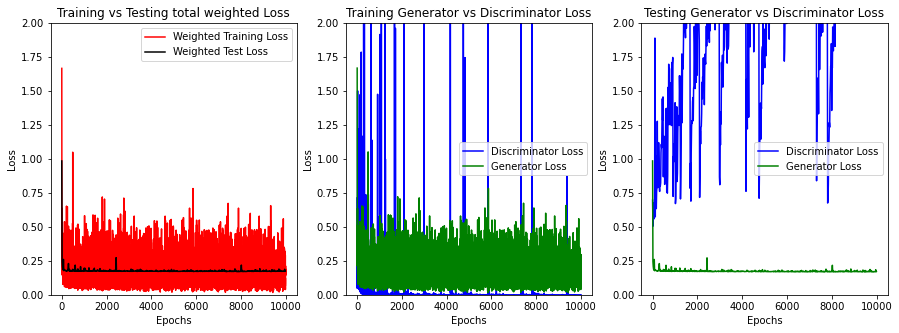

In [15]:
#graphs of losses

train_lw_total = l_weights[0]*np.array(cne.train_g_loss) + l_weights[1]*np.array(cne.train_d_loss)
epochs_plot = np.arange(1,epochs+1,1)

fig, ax = pl.subplots(1,3, figsize = (15,5))

#combined test (g+d) vs train (g+d)
ax[0].set_title("Training vs Testing total weighted Loss")
ax[0].plot(epochs_plot,train_lw_total,label="Weighted Training Loss",c='r')
ax[0].plot(np.array(cne.test_loss)[:,0],np.array(cne.test_loss)[:,3],label='Weighted Test Loss',c='k')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0,2)
ax[0].legend()

#training discriminator vs train generator, unadjusted for loss wieghts
ax[1].set_title("Training Generator vs Discriminator Loss")
ax[1].plot(epochs_plot,cne.train_d_loss,label="Discriminator Loss",c='b')
ax[1].plot(epochs_plot,cne.train_g_loss,label="Generator Loss",c='g')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,2)
#ax[1].set_yscale("log")
ax[1].legend()

#testing discriminator vs test generator, unadjusted for loss wieghts
ax[2].set_title("Testing Generator vs Discriminator Loss")
ax[2].plot(np.array(cne.test_loss)[:,0],np.array(cne.test_loss)[:,1],label='Discriminator Loss',c='b')
ax[2].plot(np.array(cne.test_loss)[:,0],np.array(cne.test_loss)[:,2],label='Generator Loss',c='g')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel('Loss')
#choose what scale, second shows much more representative shape but not realtive to other graphs
ax[2].set_ylim(0,2)
#ax[2].set_ylim(0.15,0.2)
ax[2].legend()

fig.savefig(f"network_output/images/12_all_loss__{date}.png")
plt.show()

## Make Predictions and Paper Figures

In [16]:
#get prediction for testing
#cne.predictions(images)
orig, gen_out, mean_out, mask_imgs = cne.predictions(cutouts_test)

<Figure size 432x288 with 0 Axes>

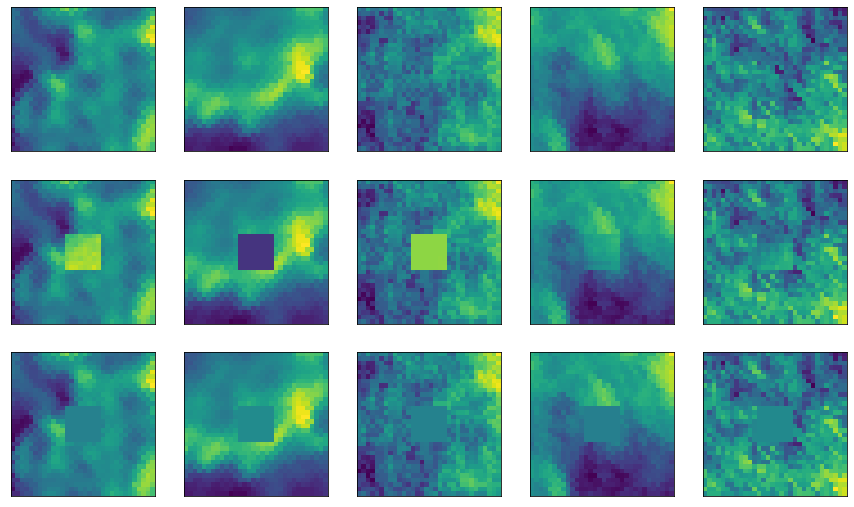

In [17]:
#figure of generated and mean corrected images
#TODO replace mean ocrrected by paerture corrected

pl.viridis()
nplots = 5
offset = 5
fig, ax = pl.subplots(3,nplots, figsize = (nplots*3., 9))

for ii in range(0,nplots):
    #original images
    ax[0,ii].imshow((orig[ii+offset,:,:]))
    ax[0,ii].xaxis.set_visible(False)
    ax[0,ii].yaxis.set_visible(False)
    
    #generated images (center region)
    ax[1,ii].imshow((gen_out[ii+offset,:,:]))
    ax[1,ii].xaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)
    
    #mean corrected images
    ax[2,ii].imshow((mean_out[ii+offset,:,:]))
    ax[2,ii].xaxis.set_visible(False)
    ax[2,ii].yaxis.set_visible(False)
    
    #Aperture correcedted images
    #
    #
    #
    #


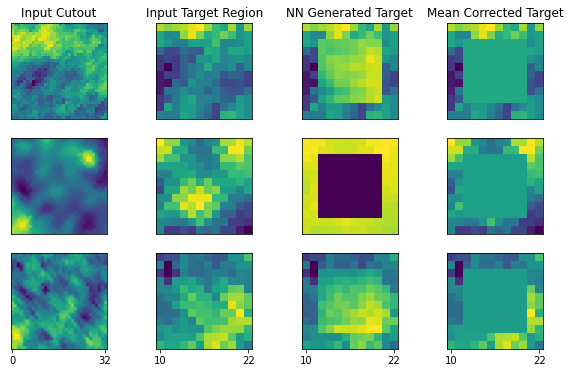

In [18]:
#figure showing good generation examples
#due to random noise these images reset between runs
#this is gueswork, so far, might be later tied to individual rms error

#visualy picked from later larger array of images
good_gens = [2,4,12]

#plot a visula comparison between original, generated, and mean
#TODO replace mean correcetd by aperture corrected
fig, ax = pl.subplots(3,4, figsize = (10,6))
for i in range(0,3):
    ax[i,0].imshow((orig[good_gens[i],:,:]))
    ax[i,1].imshow((orig[good_gens[i],10:22,10:22]))
    ax[i,2].imshow((gen_out[good_gens[i],10:22,10:22]))
    ax[i,3].imshow((mean_out[good_gens[i],10:22,10:22]))
    for ii in range(0,4):
        ax[i,ii].xaxis.set_visible(False)
        ax[i,ii].yaxis.set_visible(False)
ax[0,0].set_title("Input Cutout")
ax[0,1].set_title("Input Target Region")
ax[0,2].set_title("NN Generated Target")
ax[0,3].set_title("Mean Corrected Target")

ax[2,0].xaxis.set_visible(True)
ax[2,0].set_xticks([0,31])
ax[2,0].set_xticklabels([0,32])

#showing zoom in region
for i in range(1,4):
    ax[2,i].xaxis.set_visible(True)
    ax[2,i].set_xticks([0,11])
    ax[2,i].set_xticklabels([10,22])

fig.savefig(f"network_output/images/12_good_out__{date}.png")

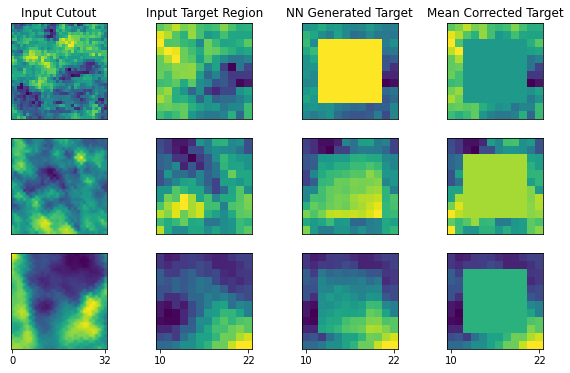

In [19]:
#bad examples, also guesswork, hopefuly as we progress less and less

bad_gens = [52,32,16]

#same thing
fig, ax = pl.subplots(3,4, figsize = (10,6))
for i in range(0,3):
    ax[i,0].imshow((orig[bad_gens[i],:,:]))
    ax[i,1].imshow((orig[bad_gens[i],10:22,10:22]))
    ax[i,2].imshow((gen_out[bad_gens[i],10:22,10:22]))
    ax[i,3].imshow((mean_out[bad_gens[i],10:22,10:22]))
    for ii in range(0,4):
        ax[i,ii].xaxis.set_visible(False)
        ax[i,ii].yaxis.set_visible(False)
ax[0,0].set_title("Input Cutout")
ax[0,1].set_title("Input Target Region")
ax[0,2].set_title("NN Generated Target")
ax[0,3].set_title("Mean Corrected Target")

ax[2,0].xaxis.set_visible(True)
ax[2,0].set_xticks([0,31])
ax[2,0].set_xticklabels([0,32])

for i in range(1,4):
    ax[2,i].xaxis.set_visible(True)
    ax[2,i].set_xticks([0,11])
    ax[2,i].set_xticklabels([10,22])

fig.savefig(f"network_output/images/12_bad_out__{date}.png")

## Plot A lot of images for visual inspection

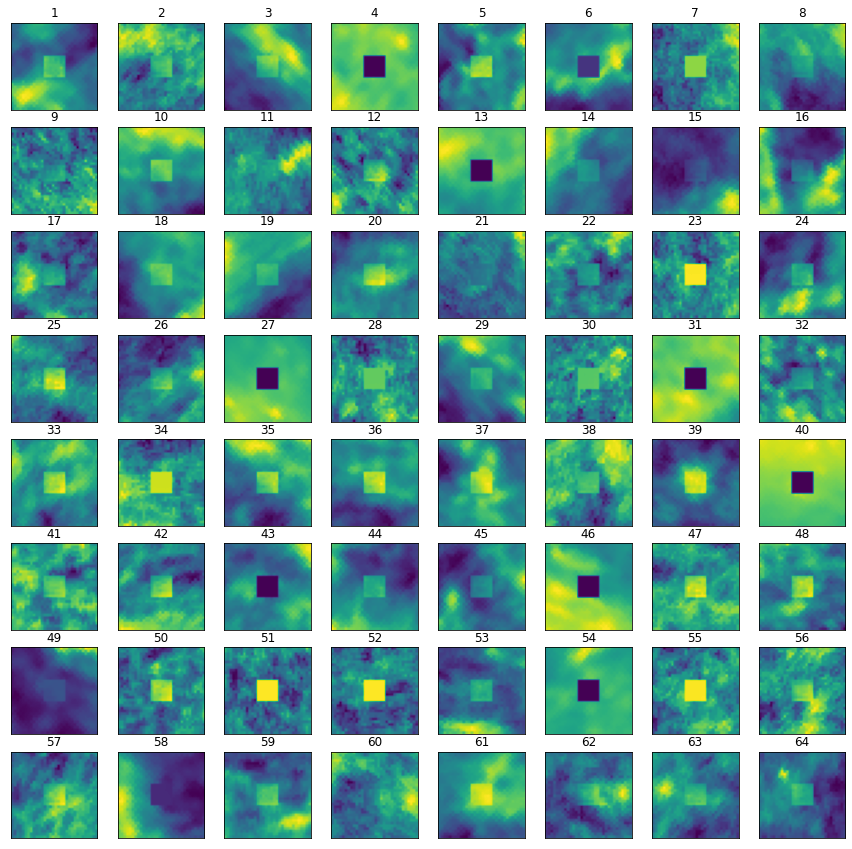

In [20]:
size = 8
fig, ax = pl.subplots(size,size, figsize = (15,15))
offset = 0
index = 0
for i in range(0,size):
    for ii in range(0,size):
        index +=1
        ax[i,ii].imshow(gen_out[(index + offset),:,:])
        ax[i,ii].xaxis.set_visible(False)
        ax[i,ii].yaxis.set_visible(False)
        ax[i,ii].set_title(f'{index + offset}')

## Network fail analysis

In [21]:
#some generated images have a near uniform values for all generated pixels
#while we decide what to do with them they will be excluded from furher analysis

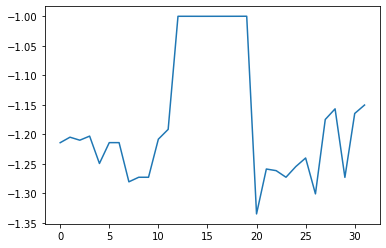

In [22]:
#a bad image, visualy inspected
#plot a slice of pixels through the "uniform" generated region to get value
#there are two versions, value =~ 1 or -1
plt.plot(gen_out[23,14,:])
#plt.ylim(0.9,1.1)

In [23]:
#filter out images that have eihter 1 or -1 in their generated regions
#TODO, this might include imagres that naturally have 1/-1 at this point
    #can redo the analysis to look for small difference between neighbourin pixels

gen_out_mod = [] #modified
gen_bad = []
orig_bad = []

for i in range(0, len(gen_out)):
    if (0.98 > gen_out[i,14,14] or gen_out[i,14,14] > 1.02):
        if (-0.98 < gen_out[i,14,14] or gen_out[i,14,14] < -1.02):
            gen_out_mod.append(gen_out[i,:,:])
        else: 
            orig_bad.append(cutouts_test[i,:,:])
            gen_bad.append(gen_out[i,:,:])
    else: 
        orig_bad.append(cutouts_test[i,:,:])
        gen_bad.append(gen_out[i,:,:])

#dataset of non-failing generated images
gen_out_mod = np.array(gen_out_mod)

#failing generated images
gen_bad = np.array(gen_bad)

#original images that were generated bad, for reasons... :|
orig_bad = np.array(orig_bad)

#get relative size of datasets
print(gen_out_mod.shape)
print(orig_bad.shape)
print(gen_bad.shape)


(6732, 32, 32, 1)
(3268, 32, 32)
(3268, 32, 32, 1)


In [24]:
#remake prediction with orig_bad
orig2, gen_out2, mean_out2, mask_imgs2 = cne.predictions(orig_bad)

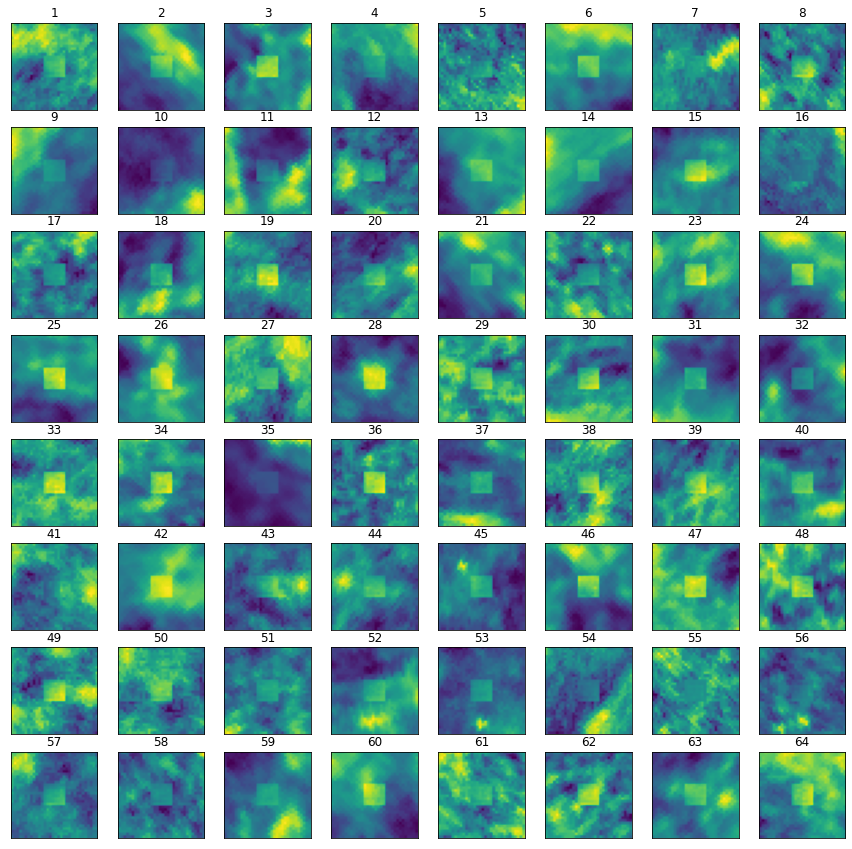

In [25]:
size = 8
fig, ax = pl.subplots(size,size, figsize = (15,15))
offset = 0
index = 0

#orig, gen_out, gen_out_mod, orig_bad, gen_bad
#orig_2, gen_out2

for i in range(0,size):
    for ii in range(0,size):
        index +=1
        ax[i,ii].imshow(gen_out_mod[(index + offset),:,:])
        ax[i,ii].xaxis.set_visible(False)
        ax[i,ii].yaxis.set_visible(False)
        ax[i,ii].set_title(f'{index + offset}')

In [26]:
#chack if the network is correctly identifying them
cne.test(orig_bad)
print(cne.test_g_loss, cne.test_d_loss)

[0.05927577242255211] [3.541016684495844]


## Numerical evaluation of a data set

[[ 0.03943802 -0.22497122]]


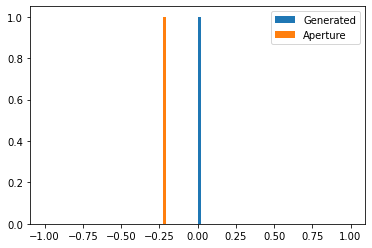

In [27]:
good = [39]
len_g = len(good)
app_sums = np.empty((len_g,3)) # real, generated, aperture

dim_mask = 4

x_tar = (int(dim_reduced/2) - int(dim_mask/2))

buffer = 5
width = 5

x_app_s = x_tar - buffer - width
x_app_e = x_tar + dim_mask + buffer + width

x_emp_s = x_tar - buffer
x_emp_e = x_tar + dim_mask + buffer

area = (x_app_e - x_app_s)**2 - (x_emp_e - x_emp_s)**2


#sum data region
new_orig = orig

for i in range(0,len_g):
    new_orig[i,:,:] = orig[i,:,:] #+ np.mean(orig[i,:,:])
    
    app_sums[i,0] = np.sum(new_orig[good[i], x_tar:x_tar+dim_mask, x_tar:x_tar+dim_mask]) / dim_mask**2
    app_sums[i,1] = np.sum(gen_out[good[i], x_tar:x_tar+dim_mask, x_tar:x_tar+dim_mask]) / dim_mask**2
    app_sums[i,2] = (np.sum(new_orig[good[i], x_app_s:x_app_e, x_app_s:x_app_e]) - 
                    np.sum(new_orig[good[i], x_emp_s:x_emp_e, x_emp_s:x_emp_e])) / area
    
#compare results
how_good = np.empty((len_g,2))
how_good[:,0] = app_sums[:,1] - app_sums[:,0]
how_good[:,1] = app_sums[:,2] - app_sums[:,0]

plt.hist((how_good[:,0], how_good[:,1]), range = (-1,1), bins = 40, label = ("Generated", "Aperture"))
plt.legend()

print(how_good)

## Aperture evaluation

In [28]:
#get all images and setup


len_g = len(gen_out_mod)
app_sums = np.empty((len_g,3)) # real, generated, aperture

dim_mask = 4

x_tar = (int(dim_reduced/2) - int(dim_mask/2))

buffer = 5
width = 5

x_app_s = x_tar - buffer - width
x_app_e = x_tar + dim_mask + buffer + width

x_emp_s = x_tar - buffer
x_emp_e = x_tar + dim_mask + buffer

area = (x_app_e - x_app_s)**2 - (x_emp_e - x_emp_s)**2


#sum data region
new_orig = orig

for i in range(0,len_g):
    new_orig[i,:,:] = orig[i,:,:] #+ np.mean(orig[i,:,:])
    
    app_sums[i,0] = np.sum(new_orig[i, x_tar:x_tar+dim_mask, x_tar:x_tar+dim_mask]) / dim_mask**2
    app_sums[i,1] = np.sum(gen_out_mod[i, x_tar:x_tar+dim_mask, x_tar:x_tar+dim_mask]) / dim_mask**2
    app_sums[i,2] = (np.sum(new_orig[i, x_app_s:x_app_e, x_app_s:x_app_e]) - 
                    np.sum(new_orig[i, x_emp_s:x_emp_e, x_emp_s:x_emp_e])) / area
    
#compare results
how_good = np.empty((len_g,2))
how_good[:,0] = app_sums[:,1] - app_sums[:,0]
how_good[:,1] = app_sums[:,2] - app_sums[:,0]

print(how_good)

[[ 2.00341707  0.00546698]
 [-1.20614033  0.03376454]
 [ 0.96681587  0.04843273]
 ...
 [ 1.18471787  0.02830769]
 [ 0.1450309   0.03070912]
 [ 0.05316812 -0.07277189]]


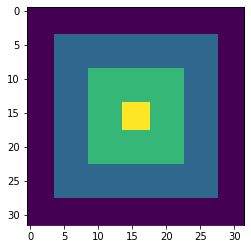

In [29]:
test = np.ones((dim_reduced,dim_reduced))
test[x_app_s:x_app_e, x_app_s:x_app_e] = 2
test[x_emp_s:x_emp_e, x_emp_s:x_emp_e] = 3
test[x_tar:x_tar+dim_mask, x_tar:x_tar+dim_mask] = 4
plt.imshow(test)

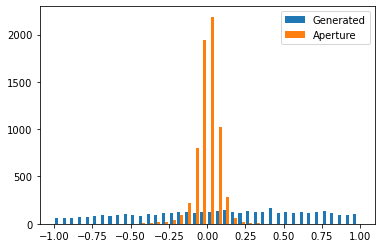

In [30]:
plt.hist((how_good[:,0], how_good[:,1]), range = (-1,1), bins = 40, label = ("Generated", "Aperture"))
plt.legend()

In [31]:
#insanely long grid search for best combination fo loss weights and batch sizes
#intensity graphs on papaer


In [32]:
#choose some good examples and redo metrcis
#understad origional very good metrics
#figure out random seed for
#look at bad examples in loss way
#extreeeme training
#find if other losses are aplicable
#test on batch
#clean up 
#push
#makea validation split ofr outside testing purposes
#aperture corr3ected images in function